<a href="https://colab.research.google.com/github/Gabriel-Groehs/Python-Finance/blob/main/Gabriel_Groehs_Selic_vs_Infla%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose

import cufflinks as cf

cf.go_offline()

In [ ]:
# Definição da função responsável por obter as séries temporais.
# code_bcb: https://www3.bcb.gov.br/sgspub/localizarseries/localizarSeries.do?method=prepararTelaLocalizarSeries
def search_bcb(code_bcb):
    url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(code_bcb)
    df = pd.read_json(url)
    df['data'] = pd.to_datetime(df['data'], dayfirst=True)
    df.set_index('data', inplace=True)
    return df

In [ ]:
selic = search_bcb(432) 
selic.columns = ["Selic_meta"]

ipca = search_bcb(433)
ipca.columns = ["IPCA"]

In [ ]:

print("Na série temporal da Selic-meta temos {} entradas, de {} até {}".format(selic.shape[0], 
                                                                               selic.index[0].strftime('%d/%m/%Y'), 
                                                                               selic.index[-1].strftime('%d/%m/%Y')))
print("Na série temporal do IPCA temos {} entradas, de {} até {}".format(ipca.shape[0], 
                                                                               ipca.index[0].strftime('%d/%m/%Y'), 
                                                                               ipca.index[-1].strftime('%d/%m/%Y')))

Na série temporal da Selic-meta temos 8679 entradas, de 05/03/1999 até 07/12/2022
Na série temporal do IPCA temos 514 entradas, de 01/01/1980 até 01/10/2022


In [ ]:
print("Valores faltantes na Selic: {}%".format(selic.isnull().sum()[0]/selic.shape[0]))
print("Valores faltantes no IPCA: {}%".format(ipca.isnull().sum()[0]/ipca.shape[0]))

Valores faltantes na Selic: 0.0%
Valores faltantes no IPCA: 0.0%


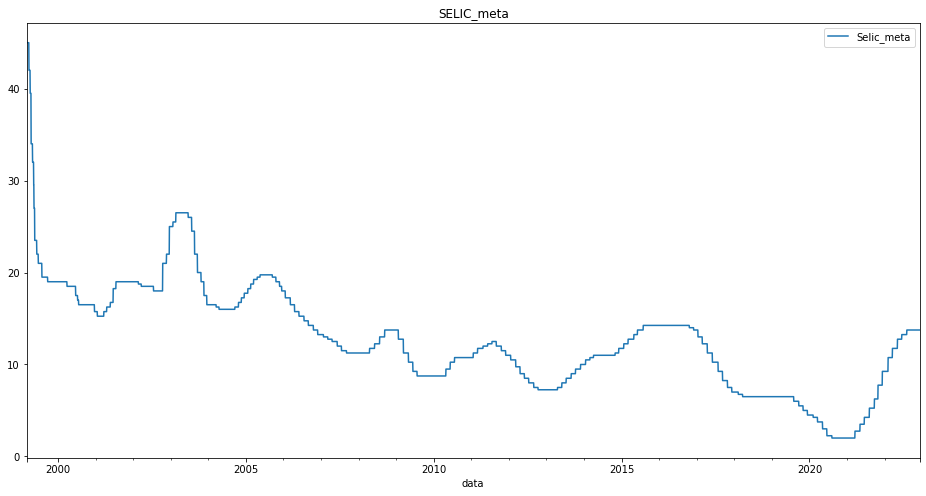

In [ ]:
selic.plot(title="SELIC_meta", figsize=(16, 8));

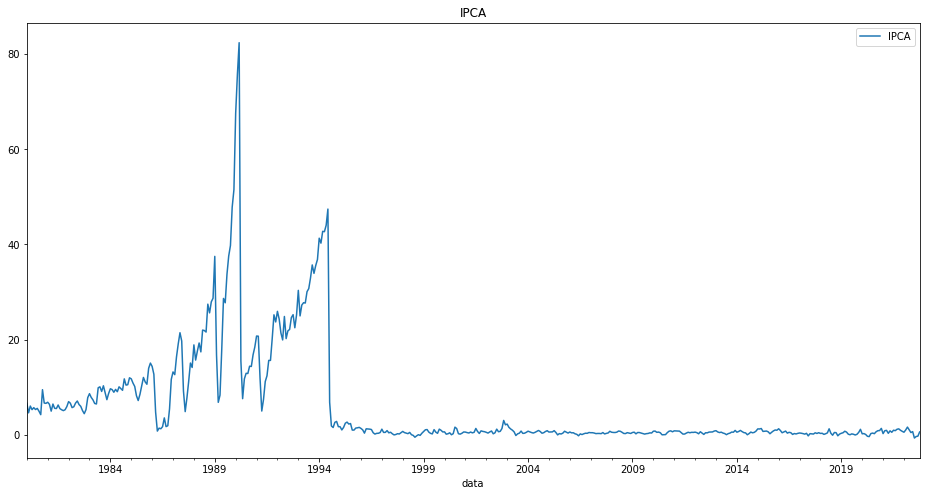

In [ ]:
ipca.plot(title="IPCA", figsize=(16, 8));

In [ ]:
# Calculando valores acumulados dos últimos 12 meses para a inflação
ipca = ipca.assign(IPCA_acm=0)
for i in range(ipca.shape[0]):
    ret = 1
    for j in range(12):
        ret = ret * (1+ipca.iloc[i-j, 0]/100)
    ipca.iloc[i, 1] = round(100*(ret-1),2)
ipca.drop(columns=["IPCA"], inplace=True)

In [ ]:
# Filtra apenas valores à partir do início do ano 2000
selic = selic[selic.index>="2000-01-01"]
ipca = ipca[ipca.index>="2000-01-01"]

In [ ]:
# Construindo um DataFrame com Selic e IPCA nas mesmas datas
df = pd.DataFrame(ipca.IPCA_acm)
df = df.assign(Selic_meta=0.00)
for i in range(df.shape[0]):
    df.iloc[i, 1] = selic.iloc[selic.index == df.index[i]]

In [ ]:
df.head(5)

,IPCA_acm,Selic_meta
data,,
2000-01-01,8.85,19.0
2000-02-01,7.86,19.0
2000-03-01,6.92,19.0
2000-04-01,6.77,18.5
2000-05-01,6.47,18.5


##Analise Exploratória Selic vs IPCA

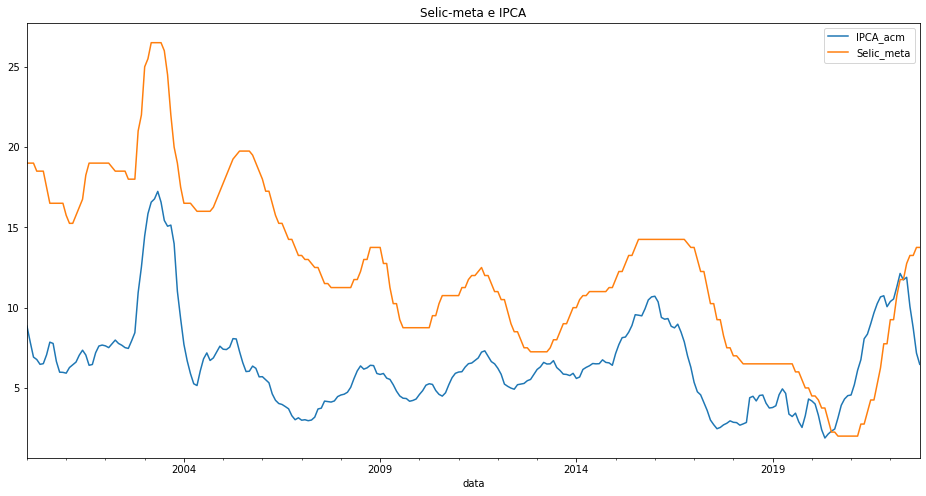

In [ ]:
df.plot(title="Selic-meta e IPCA", figsize=(16, 8));

In [ ]:
corr = 100*np.corrcoef(df.Selic_meta, df.IPCA_acm)[0][1]
print("A correlação entre Selic-meta e IPCA é de {}%".format(round(corr, 2)))

A correlação entre Selic-meta e IPCA é de 59.92%


In [ ]:
# Obtendo o componente de tendência na decomposição das séries temporais
decompose_ipca = seasonal_decompose(df.IPCA_acm)
trend_ipca = decompose_ipca.trend

decompose_selic = seasonal_decompose(df.Selic_meta)
trend_selic = decompose_selic.trend

In [ ]:
# Construindo um DataFrame com os componentes de tendência
df_trend = pd.DataFrame(df.IPCA_acm)
df_trend = df_trend.assign(Trend_IPCA = trend_ipca.tolist())
df_trend = df_trend.assign(Trend_Selic = trend_selic.tolist())
df_trend.drop(columns=["IPCA_acm"], inplace=True)
df_trend.dropna(inplace=True)

##Analise Exploratória Selic vs IPCA

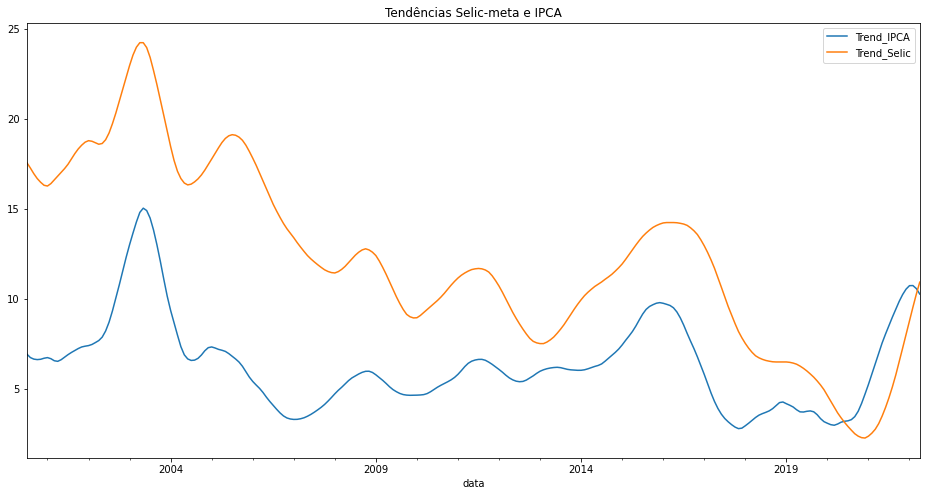

In [ ]:

df_trend.plot(title="Tendências Selic-meta e IPCA", figsize=(16, 8));

In [ ]:
corr = 100*np.corrcoef(df_trend.Trend_Selic, df_trend.Trend_IPCA)[0][1]
print("A correlação entre as tendências de Selic-meta e IPCA é de {}%".format(round(corr, 2)))

A correlação entre as tendências de Selic-meta e IPCA é de 61.69%
